Get data

In [1]:
# Make sure that you have all these libaries available to run the code successfully
import quandl
#from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.metrics import mean_squared_error

import pytz

Using TensorFlow backend.


In [14]:
# Here we only get the data in S&P 500
universe_df = pd.read_csv("sp500.csv")
universe = universe_df['Symbol'].tolist()
end_date = '2018-03-27'
begin_date = pd.Timestamp(end_date) - pd.DateOffset(months=24)
def get_stock_data(ticker):

    data_source = 'Yahoo Finance' # alphavantage or kaggle
    if data_source == 'Yahoo Finance':
        df = pd.read_csv("SP500_constitutes_modified.csv")
        df = df[["Date", ticker]]
        
    elif data_source == 'quantdl':
        # ====================== Loading Data from Quandl ==================================

        api_key = 'tv6mxJKZxRcTysJaHKc2'

        # Save data to this file
        file_to_save = 'stock_market_data-%s.csv'%ticker
        quandl.ApiConfig.api_key = api_key
         # If you haven't already saved data,
        # Go ahead and grab the data from the url
        # And store date, low, high, volume, close, open values to a Pandas DataFrame
        if not os.path.exists(file_to_save):
            df = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['date', 'close'] }, ticker = [ticker], date = { 'gte': '2016-03-27', 'lte': '2018-03-27' })        
            df.to_csv(file_to_save)
            
            # If the data is already there, just load it from the CSV
        else:
            print('File already exists. Loading data from CSV')
            df = pd.read_csv(file_to_save)
    else:
    
        # ====================== Loading Data from Kaggle ==================================
        # You will be using HP's data. Feel free to experiment with other data.
        # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
        df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
        print('Loaded data from the Kaggle repository')
    
    return df

In [26]:
testing_pair = ['CME-US', 'ICE-US']
df_1 = get_stock_data('CME-US')
df_2 = get_stock_data('ICE-US')

In [27]:
close1 = df_1[testing_pair[0]].tolist()
close2 = df_2[testing_pair[1]].tolist()
date_all = df_1.Date.tolist()
spread_close = [s1 - s2 for s1,s2 in zip(close1,close2)]
spread_df = pd.DataFrame(spread_close, index = date_all, columns = ['close']) 
spread_df

,close
11/10/17,71.61
11/13/17,73.07
11/14/17,72.90
11/15/17,73.14
11/16/17,74.01
...,...
11/22/19,113.15
11/25/19,112.48
11/26/19,111.40
11/27/19,107.55


In [34]:
def create_dataset(dataset, look_back=1):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back),0])
        dataY.append(dataset[i+look_back,0])

    return np.array(dataX), np.array(dataY)

def LSTM_model(data):

    #load data
    dataset = np.array(data['close'].values).reshape(-1,1)
    dataset = dataset.astype('float32')

    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape for look_back
    look_back = 10
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)

    # reshape for LSTM [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # LSTM
    model = Sequential()
    model.add(LSTM(32, input_dim=1)) #look_back))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, nb_epoch=20, batch_size=5, verbose=2)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test) 
    
    # scale back 
    train_pred = scaler.inverse_transform(train_pred)
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_pred = scaler.inverse_transform(test_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # shift predictions for plotting
    train_pred_plot = np.empty_like(dataset)
    train_pred_plot[:,:] = np.nan
    train_pred_plot[look_back:len(train_pred)+look_back,:] = train_pred

    test_pred_plot = np.empty_like(dataset)
    test_pred_plot[:,:] = np.nan
    test_pred_plot[len(train_pred)+(look_back*2)+1:len(dataset)-1,:] = test_pred

    f = plt.figure()
    plt.plot(scaler.inverse_transform(dataset), color='b', lw=2.0, label='S&P 500')
    plt.plot(train_pred_plot, color='g', lw=2.0, label='LSTM train')
    plt.plot(test_pred_plot, color='r', lw=2.0, label='LSTM test')
    plt.legend(loc=3)
    plt.grid(True)
    plt.show()
    return y_train, train_pred, y_test, test_pred

/Users/richardwang/anaconda3/envs/myvenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/richardwang/anaconda3/envs/myvenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, input_shape=(None, 1))`
/Users/richardwang/anaconda3/envs/myvenv/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/20
 - 4s - loss: 0.0192
Epoch 2/20
 - 1s - loss: 0.0028
Epoch 3/20
 - 1s - loss: 0.0022
Epoch 4/20
 - 1s - loss: 0.0023
Epoch 5/20
 - 1s - loss: 0.0023
Epoch 6/20
 - 1s - loss: 0.0021
Epoch 7/20
 - 1s - loss: 0.0020
Epoch 8/20
 - 1s - loss: 0.0020
Epoch 9/20
 - 1s - loss: 0.0021
Epoch 10/20
 - 1s - loss: 0.0021
Epoch 11/20
 - 1s - loss: 0.0021
Epoch 12/20
 - 1s - loss: 0.0019
Epoch 13/20
 - 1s - loss: 0.0017
Epoch 14/20
 - 1s - loss: 0.0018
Epoch 15/20
 - 1s - loss: 0.0016
Epoch 16/20
 - 1s - loss: 0.0016
Epoch 17/20
 - 1s - loss: 0.0017
Epoch 18/20
 - 1s - loss: 0.0015
Epoch 19/20
 - 1s - loss: 0.0015
Epoch 20/20
 - 1s - loss: 0.0016


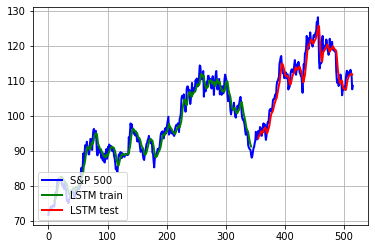

In [35]:
y_train, train_pred, y_test, test_pred = LSTM_model(spread_df)

In [30]:
error_test = list(np.array([real - test for test,real in zip(test_pred, y_test)]).flatten())
error_train = list(np.array([real - test for test,real in zip(train_pred, y_train)]).flatten())
threshold = np.std(error_test) # to be improved

In [31]:
## build up backtesting system for 
# get the return list
close_list = list(y_test.flatten())
return_list = [close1/close2 -1 for close1,close2 in zip(close_list[1:],close_list[:-1])]
signal = []
for i in range(len(close_list)):
    if error_test[i] > 1.5 * threshold:
        signal.append(1)
    elif error_test[i] < -1.5 * threshold:
        signal.append(-1)
    else:
        signal.append(0)

position_cursor = signal[0]
position = [signal[0]]
for i in range(1,len(signal)):
    if signal[i] != 0:
        if signal[i] != position[i-1]:
            position_cursor = signal[i]
    position.append(position_cursor)

In [32]:
position = position[:-1]
Capital_Line = [1]
Trading_Cost = 0.0015

for i in range(len(position)):
    if position[i] == 1:
        if i > 0 and position[i] != position[i-1]:
            Capital_Line.append(Capital_Line[i] * (1 + -1 * return_list[i] - Trading_Cost))
        else:
            Capital_Line.append(Capital_Line[i] * (1 +  -1 * return_list[i]))
    else:
        if i > 0 and position[i] != position[i-1]:
            Capital_Line.append(Capital_Line[i] * (1 + return_list[i] - Trading_Cost))
        else:
            Capital_Line.append(Capital_Line[i] * (1 +  return_list[i]))
train_size = int(len(date_all) * 0.67)
test_size = len(date_all) - train_size

date_train, date_test = date_all[0:train_size], date_all[train_size:len(date_all)]

#  Strategy Analysis
cul_return = Capital_Line[-1] - 1.0
date_line = range(len(date_test))
annual_rtn = pow(Capital_Line[-1], 250 / len(date_test)) - 1.0

# Log return
logR = [np.log(x + 1) for x in return_list]
annualVolatility = np.std(logR)
annualVolatility = annualVolatility / np.sqrt(1 / 250)
sharpe_ratio = annual_rtn / annualVolatility


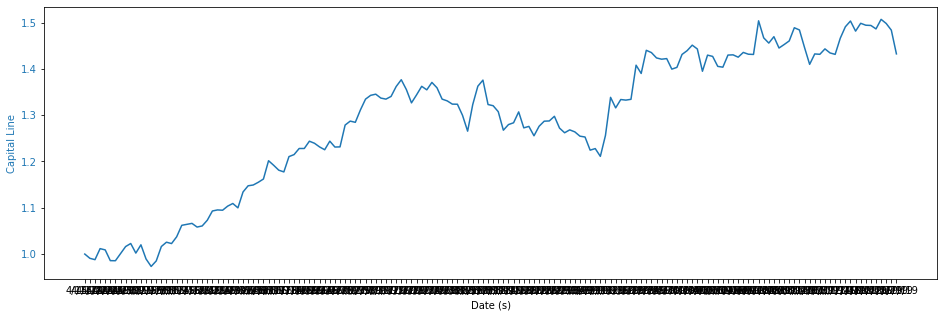

In [33]:
#register_matplotlib_converters()
fig, ax1 = plt.subplots(figsize=(16, 5))

color = 'tab:blue'
ax1.set_xlabel('Date (s)')
ax1.set_ylabel('Capital Line', color=color)
ax1.plot(date_test[11:], Capital_Line, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.show()